# Liquidation Analysis

In [1]:
#import packages
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import graphistry
import matplotlib.pyplot as plt

## Data Preparation

### Load Data

In [2]:
#load transaction data
transactions = pd.read_csv('transactions2.csv')
#filter out Aave smart contracts
transactions = transactions[~transactions['protocolContract']]
transactions.info()

/usr/local/etc/anaconda3/envs/blockchain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,13,14,16,23,24,27,28,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 685824 entries, 1 to 745611
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   amount                     484146 non-null  float64
 1   borrowRate                 104296 non-null  float64
 2   borrowRateMode             104296 non-null  object 
 3   onBehalfOf                 484146 non-null  object 
 4   pool                       685824 non-null  object 
 5   reserve                    679093 non-null  object 
 6   timestamp                  685824 non-null  int64  
 7   user                       685824 non-null  object 
 8   type                       685824 non-null  object 
 9   reservePriceETH            484146 non-null  float64
 10  reservePriceUSD            484146 non-null  float64
 11  amountUSD                  484146 non-null  float64
 12  collateralAmount           6731 non-null    float64
 13  collateralReserve          67

In [3]:
transactions['datetime'].max()

'2021-10-17 05:39:19'

### Data Cleaning

In [4]:
#filter for liquidations
liquidations = transactions[transactions['type']=='liquidation'].copy()
liquidations.dropna(axis=1,how='all',inplace=True)
liquidations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6731 entries, 180306 to 187036
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pool                       6731 non-null   object 
 1   timestamp                  6731 non-null   int64  
 2   user                       6731 non-null   object 
 3   type                       6731 non-null   object 
 4   collateralAmount           6731 non-null   float64
 5   collateralReserve          6731 non-null   object 
 6   liquidator                 6731 non-null   object 
 7   principalAmount            6731 non-null   float64
 8   principalReserve           6731 non-null   object 
 9   reservePriceETHPrincipal   6731 non-null   float64
 10  reservePriceUSDPrincipal   6731 non-null   float64
 11  reservePriceETHCollateral  6731 non-null   float64
 12  reservePriceUSDCollateral  6731 non-null   float64
 13  amountUSDPincipal          6731 non-null 

In [5]:
#create data structures to keep track of users who have been liquidated
users=dict()
liquidators=[]
nonliquidators=[]

#iterate through each users' transactions
groups = transactions.groupby('user')
for ID, group in groups:
    #check for liquidation
    if 'liquidation' in group['type'].values:
        users[ID]='Liquidatee'
        liquidators.append(ID)
    else:
        users[ID]='Non-Liquidatee'
        nonliquidators.append(ID)
        
print(len(users))

51419


In [6]:
#function to check if transaction belongs to a user who has been liquidated
def isLiquidators(row):
    if row['user'] in liquidators:
        return True
    else:
        return False

#apply to transaction data set
transactions['isLiquidatee']= transactions.apply(lambda x: isLiquidators(x),axis=1)
transactions['isLiquidatee'].describe()

count     685824
unique         2
top        False
freq      594103
Name: isLiquidatee, dtype: object

## Analysis

In [7]:
#set plot theme
sns.set_theme(style="darkgrid")

### How Many Liquidations Have Taken Place?

In [8]:
#check how many liquidations have occurred
len(liquidations)

6731

### How Many Users Have Liquidated?

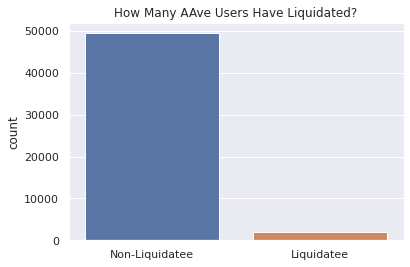

In [9]:
#create countplot
sns.countplot(x=list(users.values()))
plt.title('How Many AAve Users Have Liquidated?')
plt.show()

In [10]:
#get count of users who have been liquidated
len(liquidations['user'].unique())

1993

### How Many Liquidators are There?

In [11]:
#get count of users who have performed liquidations
len(liquidations['liquidator'].unique())

133

### How Many Actions Do Liquidators Take?

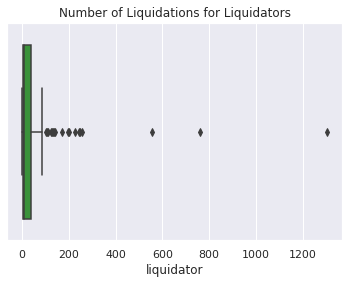

In [12]:
#create boxplot
sns.boxplot(x=liquidations['liquidator'].value_counts(),color=sns.color_palette("tab10")[2])
plt.title('Number of Liquidations for Liquidators')
plt.show()

### How Many Liquidations do Liquidatees' Recieve?

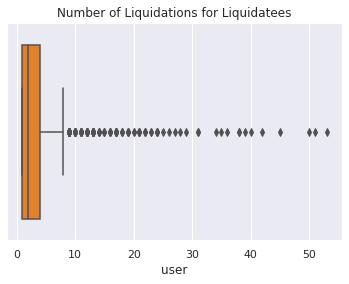

In [13]:
#create boxplot
sns.boxplot(x=liquidations['user'].value_counts(),color=sns.color_palette("tab10")[1])
plt.title('Number of Liquidations for Liquidatees')
plt.show()

### What do the Connections Between Liquidators and Liquidatees Look Like?

In [14]:
#create graph showing connection 
graphistry.register(api=3,username='Chris95cam',password='x@9DePmTfLPi@2a')
g = graphistry.edges(liquidations,'liquidator','user')
g.plot()

### What are Unique Characteristics of Liquidators vs Non Liquidators?

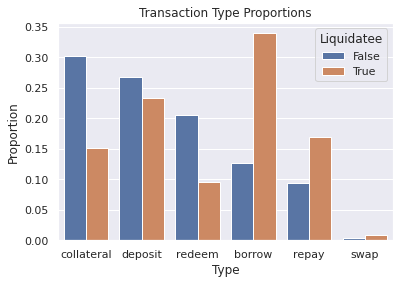

In [16]:
#get dataframes of transactions for liquidators and nonliquidators
transactions_liquidators = transactions[transactions['isLiquidatee']]
transactions_nonliquidators = transactions[~transactions['isLiquidatee']]

#get proportions of transaction types for each type of user
prop_nonliquidators = transactions_nonliquidators['type'].value_counts()/len(transactions_nonliquidators)
prop_liquidators = transactions_liquidators['type'].value_counts()[['deposit','borrow','repay','redeem','swap','collateral']]/len(transactions_liquidators[~(transactions_liquidators['type']=='liquidation')])

#create dataframe that will be used to plot data
df_props_nonliquid = pd.DataFrame(prop_nonliquidators)
df_props_nonliquid['Liquidatee']=False
df_props_liquid = pd.DataFrame(prop_liquidators)
df_props_liquid['Liquidatee']=True
df_props = df_props_nonliquid.append(df_props_liquid)
df_props.reset_index(inplace=True)

#create plot
sns.barplot(data=df_props,x='index',y='type',hue='Liquidatee')
plt.title('Transaction Type Proportions')
plt.xlabel('Type')
plt.ylabel('Proportion')
plt.show()

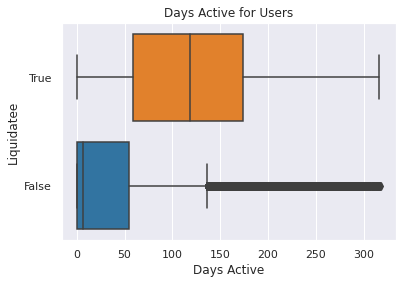

In [18]:
#get days active for both type of users
days_active_liquidators = (transactions_liquidators.groupby('user')['timestamp'].max()-transactions_liquidators.groupby('user')['timestamp'].min())/(3600*24)
days_active_nonliquidators = (transactions_nonliquidators.groupby('user')['timestamp'].max()-transactions_nonliquidators.groupby('user')['timestamp'].min())/(3600*24)

#create dataframe to be plotted
active_liquidators = pd.DataFrame(days_active_liquidators)
active_liquidators['isLiquidatee']='True'
active_nonliquidators = pd.DataFrame(days_active_nonliquidators)
active_nonliquidators['isLiquidatee']='False'
active = active_liquidators.append(active_nonliquidators)

#create boxplot
sns.boxplot(data=active,x='timestamp',y='isLiquidatee',palette=[sns.color_palette("tab10")[1],sns.color_palette("tab10")[0]])
plt.title('Days Active for Users')
plt.xlabel('Days Active')
plt.ylabel('Liquidatee')
plt.show()

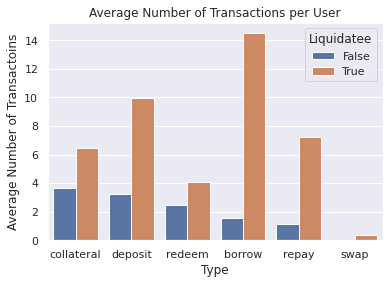

In [23]:
#get dataframes of transactions for liquidators and nonliquidators
transactions_liquidators = transactions[transactions['isLiquidatee']]
transactions_nonliquidators = transactions[~transactions['isLiquidatee']]

#get average number of transaction types per user
counts_nonliquidators = transactions_nonliquidators['type'].value_counts()/len(nonliquidators)
counts_liquidators = transactions_liquidators['type'].value_counts()[['deposit','borrow','repay','redeem','swap','collateral']]/len(liquidators)

#create dataframe that will be used to plot data
df_counts_nonliquid = pd.DataFrame(counts_nonliquidators)
df_counts_nonliquid['Liquidatee']=False
df_counts_liquid = pd.DataFrame(counts_liquidators)
df_counts_liquid['Liquidatee']=True
df_counts = df_counts_nonliquid.append(df_counts_liquid)
df_counts.reset_index(inplace=True)

#create plot
sns.barplot(data=df_counts,x='index',y='type',hue='Liquidatee')
plt.title('Average Number of Transactions per User')
plt.xlabel('Type')
plt.ylabel('Average Number of Transactoins')
plt.show()

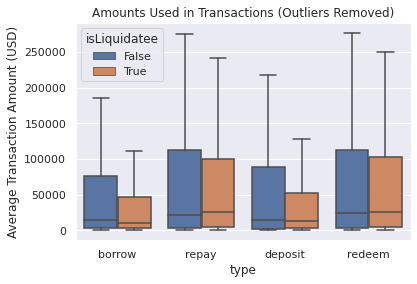

In [22]:
#create plot
sns.boxplot(data=transactions[~transactions['type'].isin(['liquidation','swap','collateral'])],x='type',y='amountUSD',hue='isLiquidatee',
            showfliers=False)
plt.title('Amounts Used in Transactions (Outliers Removed)')
plt.ylabel('Average Transaction Amount (USD)')
plt.show()

### How do the Different Attributes Correlate with Eachother?

In [ ]:
#get transactions for liquidators and non liquidators
tl = transactions_liquidators[~(transactions_liquidators['type']=='liquidation')]
tn = transactions_nonliquidators

#group by user, and calculate timeactive, and number of transactions
tl_counts = tl.groupby('user')['user'].count()
tl_times = (tl.groupby('user')['timestamp'].max()-tl.groupby('user')['timestamp'].min())/(3600*24)
tl_types= tl.groupby(['user','type']).size().unstack(fill_value=0)

tn_counts = tn.groupby('user')['user'].count()
tn_times = (tn.groupby('user')['timestamp'].max()-tn.groupby('user')['timestamp'].min())/(3600*24)
tn_types= tn.groupby(['user','type']).size().unstack(fill_value=0)

#create dataframe from values
df_tl = pd.DataFrame(tl_counts)
df_tl['daysActive']=tl_times
df_tl['isLiquidator']='True'
df_tl = df_tl.merge(tl_types,left_index=True,right_index=True)

df_tn = pd.DataFrame(tn_counts)
df_tn['daysActive']=tn_times
df_tn['isLiquidator']='False'
df_tn = df_tn.merge(tn_types,left_index=True,right_index=True)

#rename columns
df_tl.rename(columns={'user':'n','borrow':'nborrow','deposit':'ndeposit','redeem':'nredeem','repay':'nrepay','swap':'nswap','collateral':'ncollateral'},inplace=True)
df_tn.rename(columns={'user':'n','borrow':'nborrow','deposit':'ndeposit','redeem':'nredeem','repay':'nrepay','swap':'nswap','collateral':'ncollateral'},inplace=True)

#get proportions for transaction types
for t in ['borrow','deposit','redeem','repay','swap','collateral']:
    df_tl['p'+t]=df_tl['n'+t]/df_tl['n']
    df_tn['p'+t]=df_tn['n'+t]/df_tn['n']

#create dataframe for liquidator transactions and nonliquidator transactions
df_t = df_tl.append(df_tn)

#reorder columns
df_t = df_t[['isLiquidator','daysActive','n','ndeposit','nredeem','nborrow','nrepay','nswap','ncollateral','pdeposit','predeem','pborrow','prepay','pswap','pcollateral']]

#create heatmap of feature correlations
plt.figure(figsize=(9,9))
sns.heatmap(df_t.corr().round(2),annot=True)
plt.show()